In [1]:
import noisereduce as nr
import librosa
import librosa.display 
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [4]:



base_dir='sounds/new'
audio_extensions = {".wav", ".mp3"}

n_fft=1024
window='hann'
hop_length=512

output_dir = "mfcc_images"

idx=0
for i in os.listdir('sounds/new'):
    class_dir=os.path.join(base_dir,i)
    for j in os.listdir(class_dir):
        file_path = os.path.join(class_dir, j) 
        
        if os.path.isfile(file_path) and any(j.lower().endswith(ext) for ext in audio_extensions):
            y,sr=librosa.load(file_path)
            data=librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            spectrogram=np.abs(data)
            
            mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)

            # Compute MFCCs from the Mel Spectrogram
            n_mfcc = 13  # Number of MFCC coefficients
            mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), sr=sr, n_mfcc=n_mfcc)
            idx+=1
            
            plt.figure(figsize=(5, 5))
            librosa.display.specshow(mfcc, sr=sr, x_axis='time')
            plt.axis('off')  # Hide axes
            plt.savefig(f"{output_dir}/{i}/{idx}.png", bbox_inches='tight', pad_inches=0)
            plt.close()
            

In [5]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [6]:
os.listdir('mfcc_images')

['Cow', 'Dog', 'Frog']

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
data_dir = "mfcc_images"

# Custom class to exclude ".ipynb_checkpoints"
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        """Exclude '.ipynb_checkpoints' directory from class labels."""
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()  # Ensure consistent ordering
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Separate the classes
class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

# Extract indices
cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

# Create a new dataset with the filtered images
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)


def split_data(dataset):
    # Split dataset into train (70%), validation (15%), and test (15%)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    return train_dataset, val_dataset, test_dataset

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

# ---------------------- Define CNN Model ----------------------



import torch.nn.functional as F  # Ensure F is imported

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Changed Tanh to ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Changed Tanh to ReLU
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))  # Changed Tanh to ReLU
        x = self.fc2(x)  # No activation here (CrossEntropyLoss expects raw logits)
        return x


# # Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Function ----------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# ---------------------- Evaluation Function ----------------------
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

# Train the model and find the best seed for initializer
best_acc = 0
best_seed = 0
for seed in range(0,101,10):
    torch.manual_seed(seed)
    # Initialize model
    num_classes = len(dataset.classes)
    model = CNN(num_classes).to(device)
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
    # Test the model
    test_acc = evaluate_model(model, test_loader)
    print(f"Test Accuracy for seed {seed}: {test_acc:.2f}%\n")
    if(best_acc<test_acc):
        best_acc = test_acc
        best_seed = seed
    

from sklearn.metrics import f1_score
# Function to evaluate model and compute F1-score
def evaluate_model_with_f1(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get class index with highest probability
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")  # "weighted" accounts for class imbalance
    return f1
# Best Seed
# Initialize model
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.manual_seed(best_seed)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy For Best Seed {best_seed}: {test_acc:.2f}%\n")
# Compute F1-score on test set
f1_test = evaluate_model_with_f1(model, test_loader)
print(f"Test F1-Score: {f1_test:.4f}")


Using device: cpu
Total samples: 374
Training samples: 260
Validation samples: 55
Test samples: 59
Classes: ['Cow', 'Dog', 'Frog']
Epoch 1/20, Loss: 1.5283, Train Acc: 31.92%, Val Acc: 47.27%
Epoch 2/20, Loss: 1.0382, Train Acc: 53.85%, Val Acc: 52.73%
Epoch 3/20, Loss: 0.9763, Train Acc: 56.54%, Val Acc: 58.18%
Epoch 4/20, Loss: 0.8814, Train Acc: 62.31%, Val Acc: 67.27%
Epoch 5/20, Loss: 0.6916, Train Acc: 71.15%, Val Acc: 65.45%
Epoch 6/20, Loss: 0.5788, Train Acc: 73.85%, Val Acc: 74.55%
Epoch 7/20, Loss: 0.5890, Train Acc: 80.00%, Val Acc: 76.36%
Epoch 8/20, Loss: 0.4469, Train Acc: 80.00%, Val Acc: 65.45%
Epoch 9/20, Loss: 0.4761, Train Acc: 81.15%, Val Acc: 76.36%
Epoch 10/20, Loss: 0.4770, Train Acc: 81.92%, Val Acc: 74.55%
Epoch 11/20, Loss: 0.3377, Train Acc: 87.69%, Val Acc: 80.00%
Epoch 12/20, Loss: 0.2969, Train Acc: 89.62%, Val Acc: 72.73%
Epoch 13/20, Loss: 0.2887, Train Acc: 89.62%, Val Acc: 80.00%
Epoch 14/20, Loss: 0.2101, Train Acc: 93.08%, Val Acc: 80.00%
Epoch 15/2

# KNN

In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = "mfcc_images"

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

dataset = CustomImageFolder(root=data_dir, transform=transform)

class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)

def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    return random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

def extract_feature_labels(dataloader):
    feaures=[]
    labels=[]
    for imgs, lbls in dataloader:
        imgs=imgs.view(imgs.size(0),-1)
        features.extend(imgs.numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)
    
X_train, y_train = extract_features_labels(train_loader)
X_val, y_val = extract_features_labels(val_loader)
X_test, y_test = extract_features_labels(test_loader)

mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

val_preds = knn.predict(X_val)
y_pred = knn.predict(X_test)

val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds, average="weighted")

print(f"\nValidation Accuracy: {val_acc:.2f}")
# print(f"Test Accuracy: {test_acc:.2f}")
# print(f"Test F1 Score: {f1:.4f}")

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

print("\n=== Evaluation on Test Set ===")
print(f"Accuracy     : {acc:.2f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

# ---------------------- Confusion Matrix Plot ----------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Using device: cpu
Total samples: 374
Training samples: 260
Validation samples: 55
Test samples: 59
Classes: ['Cow', 'Dog', 'Frog']


NameError: name 'extract_features_labels' is not defined

# GMM

Using device: cpu
Classes: ['Cow', 'Dog', 'Frog']
Accuracy: 91.5254%


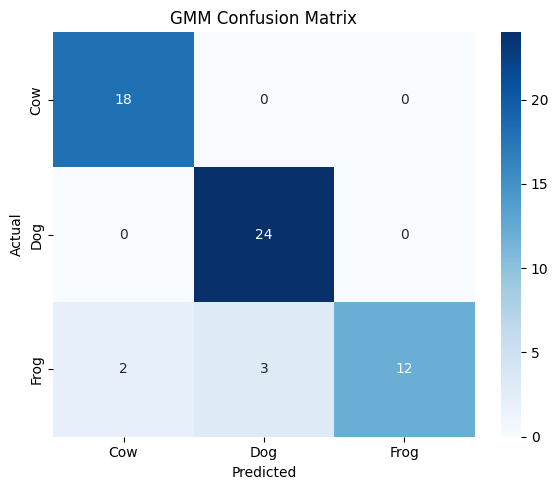


=== GMM Evaluation Metrics ===
Accuracy: 93.2203%
F1 Score     : 0.9293
Precision    : 0.9382
Recall       : 0.9322


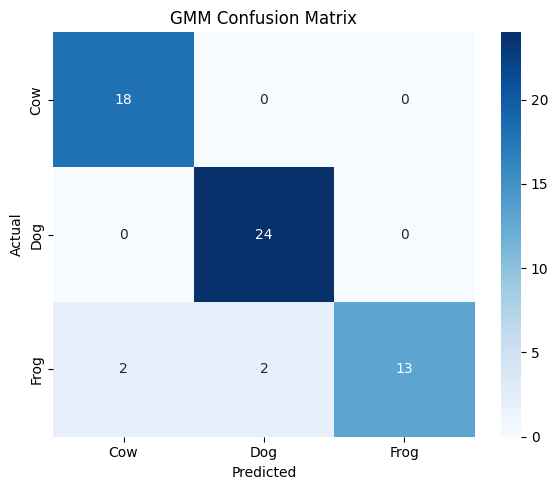

In [31]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Downscale to speed up training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom ImageFolder class to ignore checkpoints
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

data_dir = "mfcc_images"
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Get class indices
class_to_idx = dataset.class_to_idx
class_names = dataset.classes
print(f"Classes: {class_names}")

# Split by class
indices = {cls: [i for i, (_, label) in enumerate(dataset) if label == class_to_idx[cls]] for cls in class_names}
subsets = {cls: Subset(dataset, idx_list) for cls, idx_list in indices.items()}

# Split train/val/test per class
def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    return random_split(dataset, [train_size, val_size, test_size], generator=generator)

splits = {cls: split_data(subsets[cls]) for cls in class_names}
train_dataset = ConcatDataset([splits[cls][0] for cls in class_names])
val_dataset   = ConcatDataset([splits[cls][1] for cls in class_names])
test_dataset  = ConcatDataset([splits[cls][2] for cls in class_names])

# DataLoader (batch_size = 1 since we need raw features)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Helper to extract features
def extract_features_labels(loader):
    features, labels = [], []
    for img, label in loader:
        img = img.view(-1).numpy()  # Flatten image to 1D
        features.append(img)
        labels.append(label.item())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features_labels(train_loader)
X_val, y_val = extract_features_labels(val_loader)
X_test, y_test = extract_features_labels(test_loader)
pca=PCA(n_components=100, whiten=True, random_state=0)
X_train_red=pca.fit_transform(X_train)
X_test_red=pca.transform(X_test)

# Train a GMM for each class
gmm_models = {}
for cls_idx, cls_name in enumerate(class_names):
    cls_features = X_train[y_train == cls_idx]
    gmm = GaussianMixture(n_components=2, covariance_type='full', reg_covar=1e-5, random_state=0)
    gmm.fit(cls_features)
    gmm_models[cls_idx] = gmm

# Predict using the class with the highest log-likelihood
def predict_gmm(X):
    preds = []
    for x in X:
        scores = [gmm.score_samples([x])[0] for gmm in gmm_models.values()]
        preds.append(np.argmax(scores))
    return np.array(preds)

y_pred = predict_gmm(X_test)
y_p=predict_gmm(X_val)

# Metrics

acc_val = accuracy_score(y_val, y_p)*100
cmv = confusion_matrix(y_val, y_p)
print(f"Accuracy: {acc:.4f}%")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GMM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)*100

print("\n=== GMM Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}%")
print(f"F1 Score     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GMM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Downscale to speed up training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom ImageFolder class to ignore checkpoints
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

data_dir = "mfcc_images"
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Get class indices
class_to_idx = dataset.class_to_idx
class_names = dataset.classes
print(f"Classes: {class_names}")

# Split by class
indices = {cls: [i for i, (_, label) in enumerate(dataset) if label == class_to_idx[cls]] for cls in class_names}
subsets = {cls: Subset(dataset, idx_list) for cls, idx_list in indices.items()}

# Split train/val/test per class
def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    return random_split(dataset, [train_size, val_size, test_size], generator=generator)

splits = {cls: split_data(subsets[cls]) for cls in class_names}
train_dataset = ConcatDataset([splits[cls][0] for cls in class_names])
val_dataset   = ConcatDataset([splits[cls][1] for cls in class_names])
test_dataset  = ConcatDataset([splits[cls][2] for cls in class_names])

# DataLoader (batch_size = 1 since we need raw features)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Helper to extract features
def extract_features_labels(loader):
    features, labels = [], []
    for img, label in loader:
        img = img.view(-1).numpy()  # Flatten image to 1D
        features.append(img)
        labels.append(label.item())
    return np.array(features), np.array(labels)

X_train, y_train = extract_features_labels(train_loader)
X_val, y_val = extract_features_labels(val_loader)
X_test, y_test = extract_features_labels(test_loader)
pca=PCA(n_components=100, whiten=True, random_state=0)
X_train_red=pca.fit_transform(X_train)
X_test_red=pca.transform(X_test)

# Train a GMM for each class
gmm_models = {}
for cls_idx, cls_name in enumerate(class_names):
    cls_features = X_train[y_train == cls_idx]
    gmm = GaussianMixture(n_components=2, covariance_type='full', reg_covar=1e-5, random_state=0)
    gmm.fit(cls_features)
    gmm_models[cls_idx] = gmm

# Predict using the class with the highest log-likelihood
def predict_gmm(X):
    preds = []
    for x in X:
        scores = [gmm.score_samples([x])[0] for gmm in gmm_models.values()]
        preds.append(np.argmax(scores))
    return np.array(preds)

y_pred = predict_gmm(X_test)
y_p=predict_gmm(X_val)

# Metrics

acc_val = accuracy_score(y_val, y_p)*100
cmv = confusion_matrix(y_val, y_p)
print(f"Accuracy: {acc:.4f}%")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GMM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)*100

print("\n=== GMM Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}%")
print(f"F1 Score     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("GMM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



🔍 SVM Results:
Accuracy: 93.58%
Precision: 0.9394
Recall: 0.9358
F1-score: 0.9355


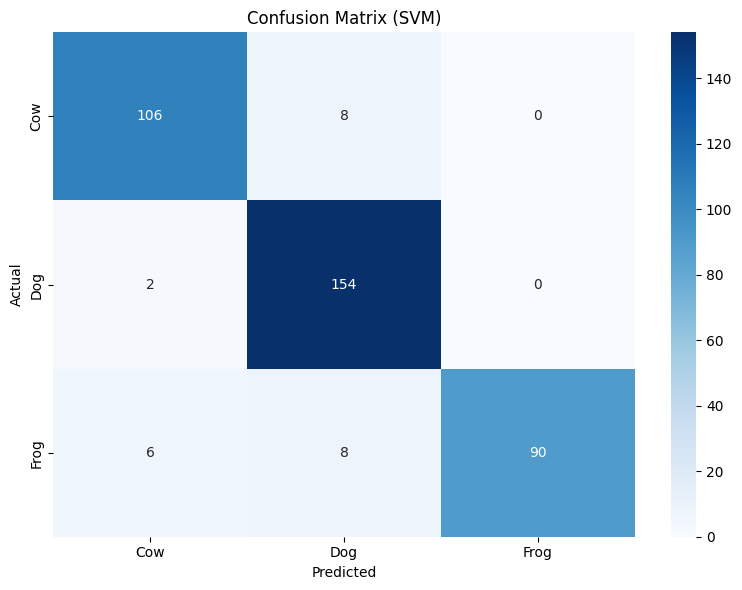

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------- Data Preprocessing ----------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
data_dir = "mfcc_images"

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
class_to_idx = dataset.class_to_idx

# Extract class-specific indices
def get_class_indices(class_name):
    class_idx = class_to_idx[class_name]
    return [i for i, (_, label) in enumerate(dataset) if label == class_idx]

subset_indices = []
for cname in class_names:
    subset_indices.extend(get_class_indices(cname))

# Use full dataset directly here (or add train/val/test splitting logic)
subset = Subset(dataset, subset_indices)
loader = DataLoader(subset, batch_size=32, shuffle=False)

# ---------------------- CNN Feature Extractor ----------------------
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 128x128x3 -> 128x128x16
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 64x64x16
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # -> 64x64x32
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 32x32x32
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)  # Flatten for SVM
        return x

feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()

# ---------------------- Extract Features ----------------------
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        features = feature_extractor(images)
        all_features.append(features.cpu())
        all_labels.append(labels)

X = torch.cat(all_features).numpy()
y = torch.cat(all_labels).numpy()

# ---------------------- Standardize Features ----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------- Train SVM ----------------------
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_scaled, y)

# ---------------------- Evaluation ----------------------
y_pred = svm.predict(X_scaled)
acc = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')
cm = confusion_matrix(y, y_pred)

print(f"\n🔍 SVM Results:")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# ---------------------- Confusion Matrix ----------------------
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM)")
plt.tight_layout()
plt.show()


Extracting features: 100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.82it/s]



=== Evaluation Metrics (SVM) ===
Accuracy     : 0.8644
F1 Score     : 0.8584
Precision    : 0.8717
Recall       : 0.8644


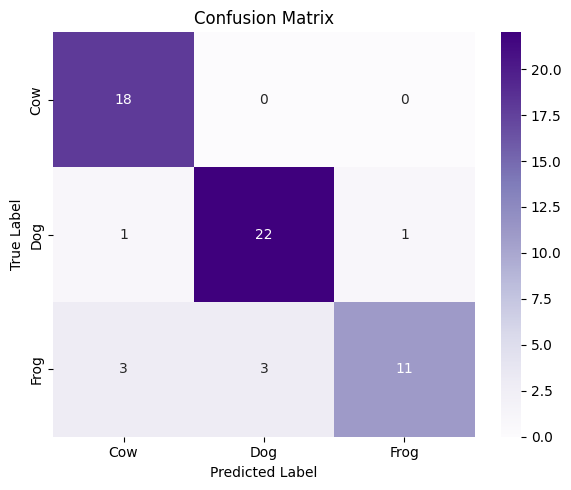

In [2]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from tqdm import tqdm

# Use same transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Exclude .ipynb_checkpoints
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

data_dir = "mfcc_images"
dataset = CustomImageFolder(root=data_dir, transform=transform)
class_to_idx = dataset.class_to_idx
class_names = dataset.classes

# Filter subsets by class
def get_class_indices(dataset, class_idx):
    return [i for i, (_, label) in enumerate(dataset) if label == class_idx]

dataset_cow = Subset(dataset, get_class_indices(dataset, class_to_idx["Cow"]))
dataset_dog = Subset(dataset, get_class_indices(dataset, class_to_idx["Dog"]))
dataset_frog = Subset(dataset, get_class_indices(dataset, class_to_idx["Frog"]))

# Split dataset
def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(4))

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

# Function to flatten image tensors to NumPy
def extract_features_labels(dataset):
    features = []
    labels = []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    for images, lbls in tqdm(loader, desc="Extracting features"):
        # Flatten images: batch_size x (3*128*128)
        images = images.view(images.size(0), -1)
        features.append(images.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Feature extraction
X_train, y_train = extract_features_labels(train_dataset)
X_val, y_val = extract_features_labels(val_dataset)
X_test, y_test = extract_features_labels(test_dataset)

# Train SVM
svm = SVC(kernel="rbf", C=1, gamma="scale")
svm.fit(X_train, y_train)

# Predict on test data
y_pred = svm.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

# Print results
print("\n=== Evaluation Metrics (SVM) ===")
print(f"Accuracy     : {acc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Using device: cpu
Training samples: 260
Validation samples: 55
Test samples: 59


Extracting CNN features: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]



=== Evaluation Metrics (CNN + SVM) ===
Accuracy     : 0.8644
F1 Score     : 0.8640
Precision    : 0.8664
Recall       : 0.8644


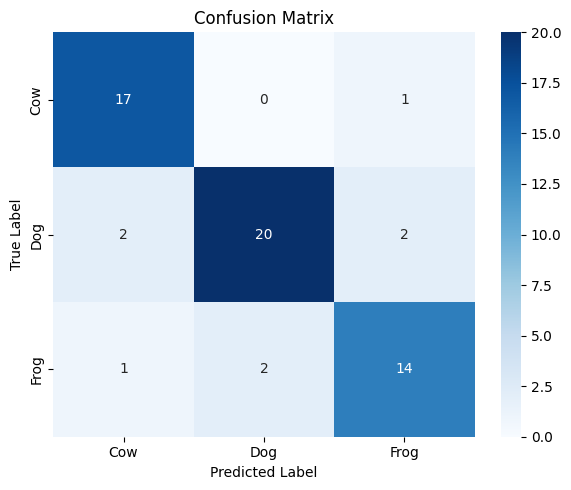

In [4]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = "mfcc_images"

# Custom class to exclude ".ipynb_checkpoints"
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes

# Filter indices by class
class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

# Create Subsets
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)

def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    return random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN Feature Extractor
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return x

# Instantiate and set to eval mode
cnn_model = CNNFeatureExtractor().to(device)
cnn_model.eval()

# Feature extraction function
def extract_cnn_features(dataset, model):
    features, labels = [], []
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    with torch.no_grad():
        for images, lbls in tqdm(loader, desc="Extracting CNN features"):
            images = images.to(device)
            out = model(images)
            features.append(out.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features
X_train, y_train = extract_cnn_features(train_dataset, cnn_model)
X_val, y_val = extract_cnn_features(val_dataset, cnn_model)
X_test, y_test = extract_cnn_features(test_dataset, cnn_model)

# Train SVM
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)
svm = SVC(kernel="rbf", C=1, gamma="scale")
svm.fit(X_scaled_train, y_train)

# Evaluate
y_pred = svm.predict(X_scaled_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
cm = confusion_matrix(y_test, y_pred)

print("\n=== Evaluation Metrics (CNN + SVM) ===")
print(f"Accuracy     : {acc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Using device: cpu
Total samples: 374
Training samples: 260
Validation samples: 55
Test samples: 59
Classes: ['Cow', 'Dog', 'Frog']
Epoch 1, Loss: 1.0613, Train Acc: 45.38%, Val Acc: 41.82%
Epoch 2, Loss: 1.0251, Train Acc: 45.00%, Val Acc: 54.55%
Epoch 3, Loss: 0.9795, Train Acc: 50.38%, Val Acc: 56.36%
Epoch 4, Loss: 0.9836, Train Acc: 60.38%, Val Acc: 60.00%
Epoch 5, Loss: 0.8891, Train Acc: 56.92%, Val Acc: 61.82%
Epoch 6, Loss: 0.8799, Train Acc: 60.00%, Val Acc: 65.45%
Epoch 7, Loss: 0.8791, Train Acc: 60.77%, Val Acc: 65.45%
Epoch 8, Loss: 0.7947, Train Acc: 71.15%, Val Acc: 67.27%
Epoch 9, Loss: 0.7528, Train Acc: 69.62%, Val Acc: 67.27%
Epoch 10, Loss: 0.6748, Train Acc: 74.62%, Val Acc: 67.27%
Epoch 11, Loss: 0.6920, Train Acc: 69.23%, Val Acc: 63.64%
Epoch 12, Loss: 0.6678, Train Acc: 69.23%, Val Acc: 67.27%
Epoch 13, Loss: 0.6730, Train Acc: 71.15%, Val Acc: 78.18%
Epoch 14, Loss: 0.5650, Train Acc: 78.08%, Val Acc: 74.55%
Epoch 15, Loss: 0.5033, Train Acc: 80.38%, Val Acc: 

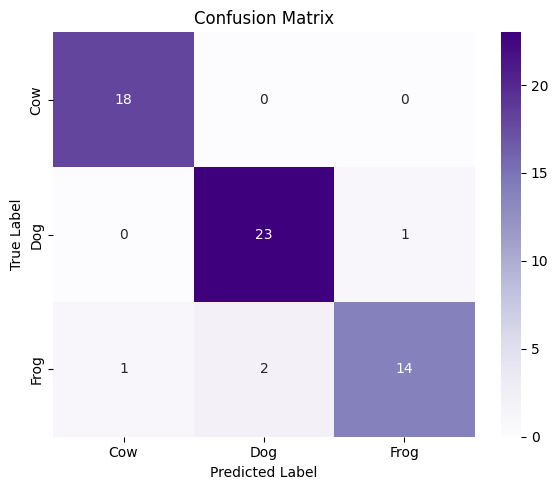

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])
data_dir = "mfcc_images"

# Custom class to exclude ".ipynb_checkpoints"
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        """Exclude '.ipynb_checkpoints' directory from class labels."""
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()  # Ensure consistent ordering
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load dataset
dataset = CustomImageFolder(root=data_dir, transform=transform)

# Separate the classes
class_to_idx = dataset.class_to_idx
cow_index = class_to_idx['Cow']
dog_index = class_to_idx['Dog']
frog_index = class_to_idx['Frog']

# Extract indices
cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_index]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_index]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_index]

# Create a new dataset with the filtered images
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)


def split_data(dataset):
    # Split dataset into train (70%), validation (15%), and test (15%)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    generator = torch.Generator().manual_seed(4)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
    return train_dataset, val_dataset, test_dataset

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes
print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

# ---------------------- Define CNN Model ----------------------



import torch.nn.functional as F  # Ensure F is imported

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Changed Tanh to ReLU
        x = self.pool(F.relu(self.conv2(x)))  # Changed Tanh to ReLU
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))  # Changed Tanh to ReLU
        x = self.fc2(x)  # No activation here (CrossEntropyLoss expects raw logits)
        return x


# # Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)

# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Function ----------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_acc = 0
    val_acc = 0
    epoch = 0
    while(val_acc<90 and train_acc<98):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        epoch+=1

# ---------------------- Evaluation Function ----------------------
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

# Train the model and find the best seed for initializer
# best_acc = 0
# best_seed = 0
# for seed in range(0,101,10):
torch.manual_seed(40)
# Initialize model
num_classes = len(dataset.classes)
model = CNN(num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# Test the model
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%\n")
# if(best_acc<test_acc):
#     best_acc = test_acc
#     best_seed = seed
    

from sklearn.metrics import f1_score
# Function to evaluate model and compute F1-score
def evaluate_model_with_metrics(model, data_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get class index with highest probability
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")  # "weighted" accounts for class imbalance
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    print("\n===Evaluation Metrics===")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    return f1
# Best Seed
# Initialize model
# num_classes = len(dataset.classes)
# model = CNN(num_classes).to(device)
# # Loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# torch.manual_seed(best_seed)
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
# # Test the model
# test_acc = evaluate_model(model, test_loader)
# print(f"Test Accuracy For Best Seed {best_seed}: {test_acc:.2f}%\n")

# Compute F1-score on test set
class_names=dataset.classes
f1_test = evaluate_model_with_metrics(model, test_loader, class_names=class_names)
# print(f"Test F1-Score: {f1_test:.4f}")


Using: cpu
Total: 374
Train: 260 Val: 55 Test: 59
Classes: ['Cow', 'Dog', 'Frog']
Epoch 1 | Loss: 1.0755 | Train Acc: 41.92% | Val Acc: 41.82%
Epoch 2 | Loss: 1.0604 | Train Acc: 41.92% | Val Acc: 43.64%
Epoch 3 | Loss: 1.0576 | Train Acc: 47.31% | Val Acc: 52.73%
Epoch 4 | Loss: 0.9864 | Train Acc: 50.77% | Val Acc: 52.73%
Epoch 5 | Loss: 0.9990 | Train Acc: 49.62% | Val Acc: 60.00%
Epoch 6 | Loss: 0.9236 | Train Acc: 60.00% | Val Acc: 65.45%
Epoch 7 | Loss: 0.9380 | Train Acc: 58.46% | Val Acc: 61.82%
Epoch 8 | Loss: 0.8002 | Train Acc: 64.62% | Val Acc: 65.45%
Epoch 9 | Loss: 0.7498 | Train Acc: 71.54% | Val Acc: 67.27%
Epoch 10 | Loss: 0.6950 | Train Acc: 69.62% | Val Acc: 69.09%
Epoch 11 | Loss: 0.7273 | Train Acc: 70.77% | Val Acc: 65.45%
Epoch 12 | Loss: 0.6602 | Train Acc: 72.31% | Val Acc: 69.09%
Epoch 13 | Loss: 0.5718 | Train Acc: 76.92% | Val Acc: 65.45%
Epoch 14 | Loss: 0.5374 | Train Acc: 80.77% | Val Acc: 61.82%
Epoch 15 | Loss: 0.5595 | Train Acc: 78.85% | Val Acc: 49.0

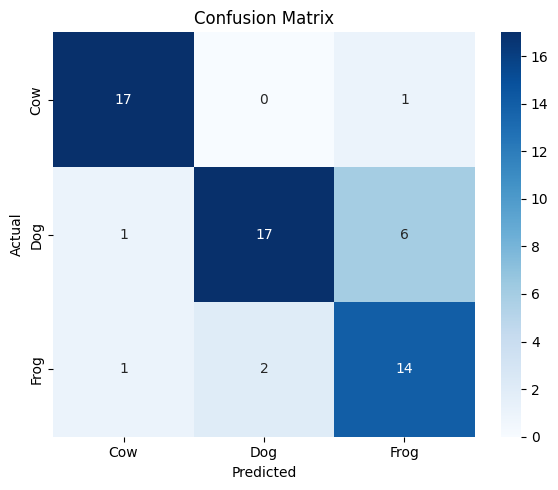

In [8]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Custom dataset class to skip .ipynb_checkpoints
class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d)) and d != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls: i for i, cls in enumerate(classes)}
        return classes, class_to_idx

# Load data
data_dir = "mfcc_images"
dataset = CustomImageFolder(data_dir, transform=transform)

# Split by class
class_to_idx = dataset.class_to_idx
cow_idx, dog_idx, frog_idx = class_to_idx['Cow'], class_to_idx['Dog'], class_to_idx['Frog']
cow_indices = [i for i, (_, label) in enumerate(dataset) if label == cow_idx]
dog_indices = [i for i, (_, label) in enumerate(dataset) if label == dog_idx]
frog_indices = [i for i, (_, label) in enumerate(dataset) if label == frog_idx]
dataset_cow = Subset(dataset, cow_indices)
dataset_dog = Subset(dataset, dog_indices)
dataset_frog = Subset(dataset, frog_indices)

def split_data(dataset):
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(4))

train_cow, val_cow, test_cow = split_data(dataset_cow)
train_dog, val_dog, test_dog = split_data(dataset_dog)
train_frog, val_frog, test_frog = split_data(dataset_frog)

train_dataset = ConcatDataset([train_cow, train_dog, train_frog])
val_dataset = ConcatDataset([val_cow, val_dog, val_frog])
test_dataset = ConcatDataset([test_cow, test_dog, test_frog])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Total:", len(dataset))
print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))
print("Classes:", dataset.classes)

# ---------------------- BiLSTM Model ----------------------

class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16

        self.lstm_input_size = 64 * 16  # 64 channels × 16 columns (treat each row as time step)
        self.hidden_size = 128
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=self.hidden_size,
                            num_layers=1, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(2 * self.hidden_size, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # -> (B, 16, 64, 64)
        x = self.pool2(F.relu(self.conv2(x)))  # -> (B, 32, 32, 32)
        x = self.pool3(F.relu(self.conv3(x)))  # -> (B, 64, 16, 16)

        x = x.permute(0, 2, 1, 3)  # -> (B, time=16, channels=64, features=16)
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # (B, time=16, 64*16)

        lstm_out, _ = self.lstm(x)  # (B, time, 2*hidden)
        out = self.fc(lstm_out[:, -1, :])  # Take last time step
        return out

# ---------------------- Training & Evaluation ----------------------

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

def evaluate_with_metrics(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print("\n=== Evaluation Metrics ===")
    print(f"Accuracy     : {np.mean(np.array(all_preds) == np.array(all_labels)) * 100:.2f}%")
    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# ---------------------- Run ----------------------

num_classes = len(dataset.classes)
model = CNN_BiLSTM(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
evaluate_with_metrics(model, test_loader, class_names=dataset.classes)


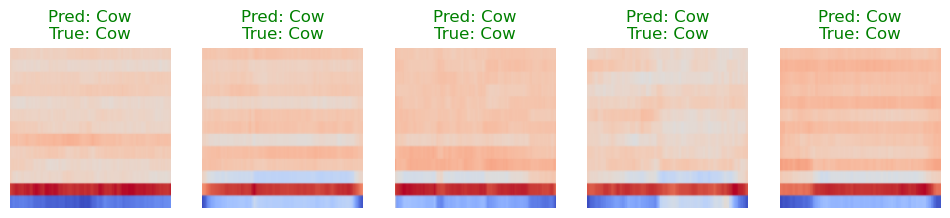

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images with predictions
def show_predictions(model, data_loader, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    images_shown = 0
    
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            
            for i in range(num_images):
                image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to image
                image = (image * 0.5) + 0.5  # Denormalize

                axes[i].imshow(image)
                axes[i].axis('off')
                axes[i].set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                                  color=("green" if preds[i] == labels[i] else "red"))

                images_shown += 1
                if images_shown == num_images:
                    break
            if images_shown == num_images:
                break
                
    plt.show()

# Call the function to visualize predictions
show_predictions(model, test_loader, dataset.classes, num_images=5)
